## Basic RNNs in Tensorflow

## Manual RNN

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import os

In [3]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [6]:
print(Y0_val)

[[ 0.628564    0.82036871 -0.43267068  0.99046588  0.98627245]
 [ 0.90669626  0.99947572  0.99314529  0.99997878  0.99993414]
 [ 0.97921991  0.99999863  0.99999064  0.99999994  0.9999997 ]
 [ 0.97056645  0.56628424  1.         -0.99999261  0.76347905]]


In [7]:
print(Y1_val)

[[ 0.79985541  0.9999966   1.          0.99941963  0.99999988]
 [-0.96598208 -0.99968129  0.89973658  0.61857086  0.98743314]
 [-0.87714612  0.3589578   1.          0.99949235  0.99996489]
 [-0.99917436 -0.97654021  0.98842126  0.85279     0.99666935]]


## Using static_rnn()

In [9]:
n_inputs = 3
n_neurons = 5

tf.reset_default_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[-0.93580759,  0.64212167,  0.87997723, -0.52154297, -0.85036987],
       [-0.99999583,  0.61757487,  0.99950773,  0.17806683, -0.99644625],
       [-1.        ,  0.59176308,  0.99999815,  0.73449904, -0.99992156],
       [-0.9997282 , -0.98424631,  0.08843344,  0.99799645,  0.57472724]], dtype=float32)

In [12]:
Y1_val

array([[-1.        , -0.88065445,  0.99999905,  0.91136628, -0.99997938],
       [-0.4848381 , -0.1794419 ,  0.52857351, -0.7373243 , -0.88959992],
       [-0.99999988, -0.62168854,  0.999906  ,  0.90746075, -0.99933368],
       [-0.98785943,  0.41035658,  0.99073976,  0.98500013, -0.51841772]], dtype=float32)

In [13]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
show_graph(tf.get_default_graph())

## Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)

[[[-0.53012955 -0.74031252 -0.2601696   0.70621401  0.92504853]
  [-0.99989092 -0.99999988  0.99771881  0.99989969  0.99651915]]

 [[-0.988033   -0.99905318  0.72410583  0.98827076  0.99551255]
  [ 0.39149114 -0.72797728 -0.15644619  0.57123524  0.6852029 ]]

 [[-0.99976391 -0.99999696  0.97037834  0.99959582  0.9997403 ]
  [-0.99504441 -0.99998224  0.98716259  0.99561167  0.97043622]]

 [[-0.95695829 -0.99998927  0.88228405 -0.91193801 -0.99923766]
  [-0.46347323 -0.96613032  0.99466664  0.43187359 -0.01708773]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.99989092 -0.99999988  0.99771881  0.99989969  0.99651915]
 [ 0.39149114 -0.72797728 -0.15644619  0.57123524  0.6852029 ]
 [-0.99504441 -0.99998224  0.98716259  0.99561167  0.97043622]
 [-0.46347323 -0.96613032  0.99466664  0.43187359 -0.01708773]]


## Using dynamic_rnn()

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [22]:
init = tf.global_variables_initializer()

In [23]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [24]:
print(outputs_val)

[[[ 0.28495687  0.86092359 -0.84053653  0.30362713  0.12867132]
  [ 0.99551183 -0.16605876 -1.          0.99977517  0.99690968]]

 [[ 0.87933397  0.93472224 -0.99982709  0.96591181  0.82923341]
  [ 0.25752622  0.29272658 -0.11316348 -0.50675184  0.18410875]]

 [[ 0.98529249  0.96999228 -0.99999976  0.99887496  0.97767419]
  [ 0.97204119 -0.14661182 -0.99997848  0.98523223  0.97596443]]

 [[ 0.99849057 -0.99992281 -0.99961042  0.9999187   0.9999215 ]
  [ 0.18135801 -0.75211531 -0.99397528  0.88598675  0.85853606]]]


In [25]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [26]:
n_steps = 2
n_inputs = 3
n_neurons = 5

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

init = tf.global_variables_initializer()

In [27]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [28]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [29]:
print(outputs_val)

[[[ 0.76096582 -0.79127848  0.6907292  -0.8733561   0.8190853 ]
  [ 0.91551316 -0.99999374  1.         -0.99993092  1.        ]]

 [[ 0.98784131 -0.99857849  0.99913698 -0.99767101  0.99984992]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.99944896 -0.9999913   0.99999791 -0.99995983  0.99999976]
  [-0.49868706 -0.99914533  0.99999416 -0.99671453  0.99999124]]

 [[ 0.97250795 -0.99959075  0.99938613  0.98053938  0.99865234]
  [-0.76745635 -0.98841697  0.9929648  -0.46041933  0.99717665]]]


In [30]:
print(states_val)

[[ 0.91551316 -0.99999374  1.         -0.99993092  1.        ]
 [ 0.98784131 -0.99857849  0.99913698 -0.99767101  0.99984992]
 [-0.49868706 -0.99914533  0.99999416 -0.99671453  0.99999124]
 [-0.76745635 -0.98841697  0.9929648  -0.46041933  0.99717665]]


## Training a sequence classifier

In [3]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [5]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94 Test accuracy: 0.9266
1 Train accuracy: 0.973333 Test accuracy: 0.944
2 Train accuracy: 0.953333 Test accuracy: 0.9544
3 Train accuracy: 0.993333 Test accuracy: 0.9589
4 Train accuracy: 0.986667 Test accuracy: 0.9586
5 Train accuracy: 0.986667 Test accuracy: 0.9557
6 Train accuracy: 0.98 Test accuracy: 0.9667
7 Train accuracy: 0.966667 Test accuracy: 0.966
8 Train accuracy: 0.98 Test accuracy: 0.969
9 Train accuracy: 0.98 Test accuracy: 0.9672
10 Train accuracy: 0.98 Test accuracy: 0.9734
11 Train accuracy: 0.986667 Test accuracy: 0.977
12 Train accuracy: 1.0 Test accuracy: 0.9731
13 Train accuracy: 0.986667 Test accuracy: 0.9708
14 Train accuracy: 0.98 Test accuracy: 0.9686
15 Train accuracy: 0.973333 Test accuracy: 0.971
16 Train accuracy: 0.986667 Test accuracy: 0.977
17 Train accuracy: 0.966667 Test accuracy: 0.9725
18 Train accuracy: 1.0 Test accuracy: 0.9778
19 Train accuracy: 1.0 Test accuracy: 0.9781
20 Train accuracy: 1.0 Test accuracy: 0.9763
21 Train a

## Multi-layer RNN

In [9]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [10]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [11]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [12]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.933333 Test accuracy: 0.9438
1 Train accuracy: 0.973333 Test accuracy: 0.9539
2 Train accuracy: 0.986667 Test accuracy: 0.971
3 Train accuracy: 0.98 Test accuracy: 0.9705
4 Train accuracy: 0.973333 Test accuracy: 0.9777
5 Train accuracy: 0.993333 Test accuracy: 0.9725
6 Train accuracy: 1.0 Test accuracy: 0.9779
7 Train accuracy: 1.0 Test accuracy: 0.9794
8 Train accuracy: 0.986667 Test accuracy: 0.984
9 Train accuracy: 0.986667 Test accuracy: 0.9826


## Time series

In [23]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

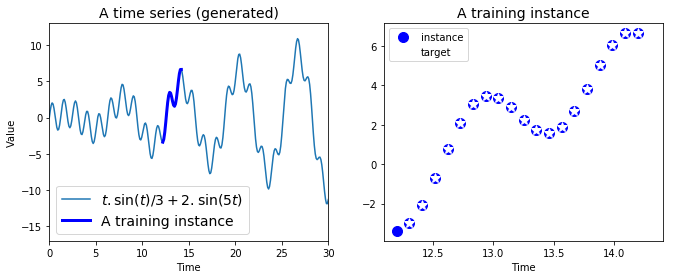

In [24]:
import matplotlib.pyplot as plt
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

In [17]:
X_batch, y_batch = next_batch(1, n_steps)

In [18]:
np.c_[X_batch[0], y_batch[0]]

array([[ 4.12245575,  3.69098406],
       [ 3.69098406,  3.29214747],
       [ 3.29214747,  3.14469916],
       [ 3.14469916,  3.39641574],
       [ 3.39641574,  4.0866879 ],
       [ 4.0866879 ,  5.13574388],
       [ 5.13574388,  6.36315689],
       [ 6.36315689,  7.53111663],
       [ 7.53111663,  8.40188114],
       [ 8.40188114,  8.79535177],
       [ 8.79535177,  8.63268286],
       [ 8.63268286,  7.95525518],
       [ 7.95525518,  6.91437287],
       [ 6.91437287,  5.7342095 ],
       [ 5.7342095 ,  4.65707705],
       [ 4.65707705,  3.88441789],
       [ 3.88441789,  3.52796523],
       [ 3.52796523,  3.58302627],
       [ 3.58302627,  3.93042429],
       [ 3.93042429,  4.36661741]])

## Using an OuputProjectionWrapper

In [19]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [20]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [21]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 18.351
100 	MSE: 0.664947
200 	MSE: 0.192222
300 	MSE: 0.111091
400 	MSE: 0.0648405
500 	MSE: 0.0568939
600 	MSE: 0.0565438
700 	MSE: 0.0452376
800 	MSE: 0.0448844
900 	MSE: 0.0553776
1000 	MSE: 0.0587005
1100 	MSE: 0.0529363
1200 	MSE: 0.0430268
1300 	MSE: 0.0508901
1400 	MSE: 0.0468102


In [25]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [26]:
y_pred

array([[[-3.44298792],
        [-2.47540879],
        [-1.07947826],
        [ 0.71681267],
        [ 2.10269427],
        [ 3.04329419],
        [ 3.50546789],
        [ 3.35304785],
        [ 2.82048202],
        [ 2.14647055],
        [ 1.67808938],
        [ 1.55282068],
        [ 1.92808259],
        [ 2.75493503],
        [ 3.89190602],
        [ 5.0852704 ],
        [ 6.05770588],
        [ 6.60556507],
        [ 6.61015129],
        [ 6.04661369]]], dtype=float32)

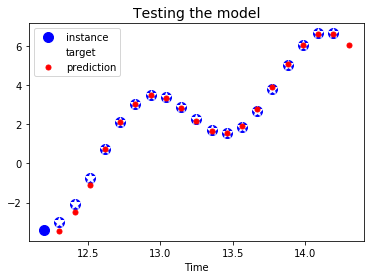

In [27]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

## Without using an OutputProjectionWrapper

In [28]:
tf.reset_default_graph()
n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [29]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [30]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 14.8732
100 	MSE: 0.512201
200 	MSE: 0.139621
300 	MSE: 0.0768282
400 	MSE: 0.0515606
500 	MSE: 0.0544869
600 	MSE: 0.0561209
700 	MSE: 0.0535197
800 	MSE: 0.0563501
900 	MSE: 0.0565144
1000 	MSE: 0.0445745
1100 	MSE: 0.0487472
1200 	MSE: 0.0420141
1300 	MSE: 0.0469158
1400 	MSE: 0.0478698


In [31]:
y_pred

array([[[-3.41598797],
        [-2.48488426],
        [-1.17650306],
        [ 0.72462022],
        [ 2.13674927],
        [ 3.07034349],
        [ 3.49354434],
        [ 3.31509161],
        [ 2.77287436],
        [ 2.13547635],
        [ 1.67036653],
        [ 1.56779683],
        [ 1.88259041],
        [ 2.68378901],
        [ 3.87855911],
        [ 5.10413218],
        [ 6.04017639],
        [ 6.62920523],
        [ 6.62911844],
        [ 6.06201077]]], dtype=float32)

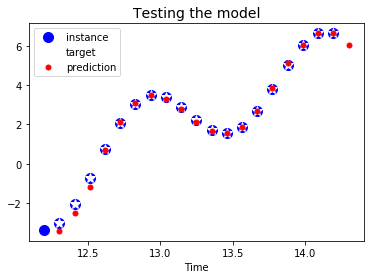

In [32]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [33]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


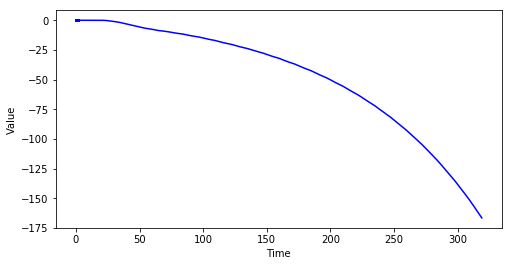

In [34]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model


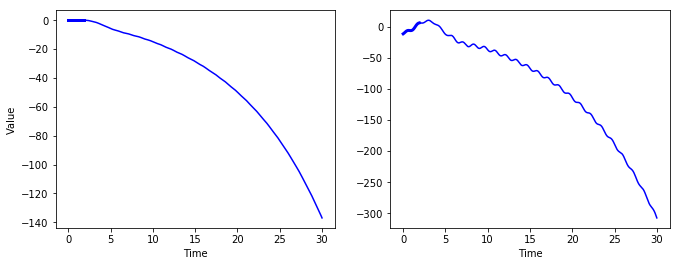

In [37]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")

plt.show()

## Deep RNN

In [38]:
tf.reset_default_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [39]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [40]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [41]:
outputs_val.shape

(2, 5, 100)

In [42]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [43]:
tf.reset_default_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [44]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [45]:
init = tf.global_variables_initializer()

In [46]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-0.06155632  0.05932296 -0.10417011 ...,  0.09017359 -0.02969709
    0.03921985]
  [-0.14245749  0.03432222 -0.1736421  ...,  0.00679919 -0.28824782
   -0.05423911]
  [-0.14713994  0.06474572 -0.21727006 ...,  0.35207611 -0.25808263
   -0.31869161]
  ..., 
  [-0.47961435 -0.23948586 -0.41178936 ..., -0.02405699 -0.33973524
   -0.44053257]
  [-0.38654652 -0.13948071 -0.46027535 ...,  0.00841945 -0.42329329
   -0.19670497]
  [-0.41918933 -0.00293406 -0.51524186 ..., -0.28612044 -0.55772448
   -0.44359964]]

 [[-0.07786248  0.06386889 -0.1115039  ...,  0.10059815 -0.04446955
    0.0129916 ]
  [-0.14063938  0.04977085 -0.19618253 ..., -0.03135468 -0.26079208
   -0.07242969]
  [-0.13891341  0.11112957 -0.05994582 ...,  0.32685453 -0.26643142
   -0.34872836]
  ..., 
  [-0.53422344  0.29870552 -0.20647304 ...,  0.0269172  -0.34107518
   -0.33100563]
  [-0.35361266 -0.00456203  0.04158042 ..., -0.20214765 -0.45643401
   -0.07275401]
  [-0.32772419 -0.00188429 -0.35490531 ..., -0.34670976  0

## Dropout

In [47]:
tf.reset_default_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [48]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [49]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [50]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [51]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 21.4299
100 Training MSE: 5.35854
200 Training MSE: 3.89377
300 Training MSE: 3.69636
400 Training MSE: 4.18282
500 Training MSE: 3.63425
600 Training MSE: 3.77756
700 Training MSE: 4.25312
800 Training MSE: 3.79609
900 Training MSE: 3.524
1000 Training MSE: 4.0418
1100 Training MSE: 3.05796
1200 Training MSE: 3.4395
1300 Training MSE: 4.17704
1400 Training MSE: 3.83908


In [52]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


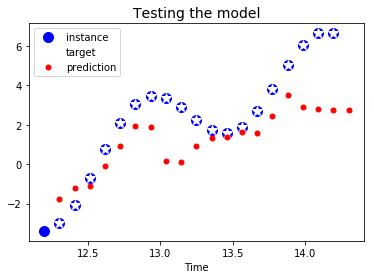

In [53]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## LSTM

In [54]:
tf.reset_default_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [55]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [56]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [57]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [58]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.953333 Test accuracy = 0.9471
Epoch 1 Train accuracy = 0.993333 Test accuracy = 0.9699
Epoch 2 Train accuracy = 0.993333 Test accuracy = 0.9783
Epoch 3 Train accuracy = 0.993333 Test accuracy = 0.9786
Epoch 4 Train accuracy = 0.993333 Test accuracy = 0.9799
Epoch 5 Train accuracy = 1.0 Test accuracy = 0.9837
Epoch 6 Train accuracy = 0.98 Test accuracy = 0.9844
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9882
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9842
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9891


In [59]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

## Embeddings

### Fetch the data

In [62]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [63]:
words = fetch_words_data()
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [64]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [65]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [66]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [67]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [68]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [69]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [70]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [71]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[5234],
        [  12],
        [   6],
        [3081],
        [ 195],
        [  12],
        [   2],
        [   6]], dtype=int32),
 ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a'])

## Build the model

In [72]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [73]:
tf.reset_default_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [74]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [75]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  317.871704102
Nearest to may: begs, breakbeat, atahualpa, finishes, lender, refutation, india, appreciable,
Nearest to as: numbering, bokassa, sgt, devoting, exploded, originate, morava, marrakesh,
Nearest to other: consort, realists, anaximander, frightful, lille, gustloff, doodle, wissenschaften,
Nearest to by: malts, mobilized, excrement, keitel, bua, prosperous, detectives, pontius,
Nearest to so: intentional, footage, definition, yog, chords, strictly, healy, crustaceans,
Nearest to states: meme, mays, boomerangs, partners, suffering, paralysis, electrodes, retire,
Nearest to united: pacing, beaufort, rotated, caledonia, sill, motley, explosives, mutilated,
Nearest to was: textual, multiplied, africanus, tuff, improperly, placements, sixty, gadol,
Nearest to that: pietro, consisting, brutal, rhenish, rayner, burlesque, takashi, buds,
Nearest to an: autocephalous, knot, provide, cake, zebrafish, participates, mjs, booms,
Nearest to eight: dat

In [76]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [77]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

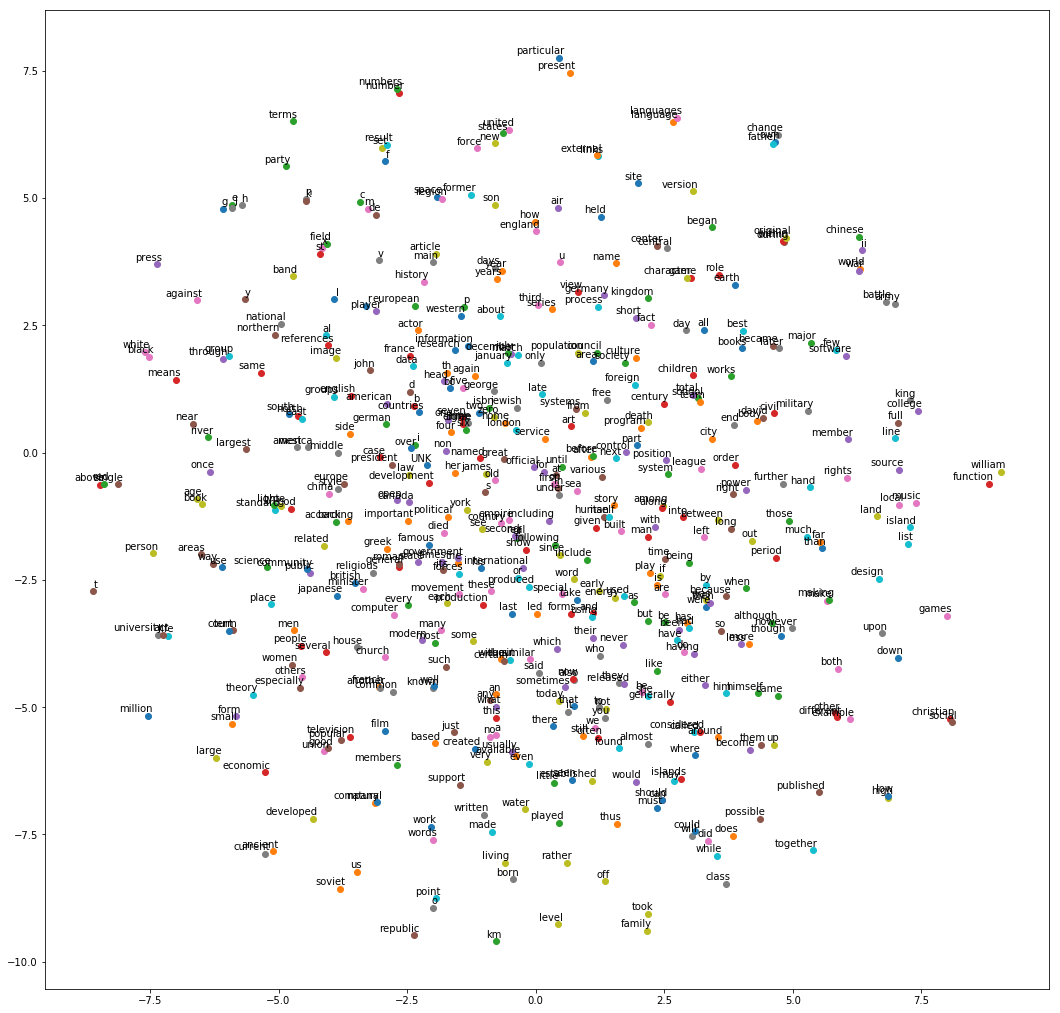

In [83]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
plt.show()

## Machine Translation

In [80]:
import tensorflow as tf

tf.reset_default_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [81]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()